# CARSHOPEE

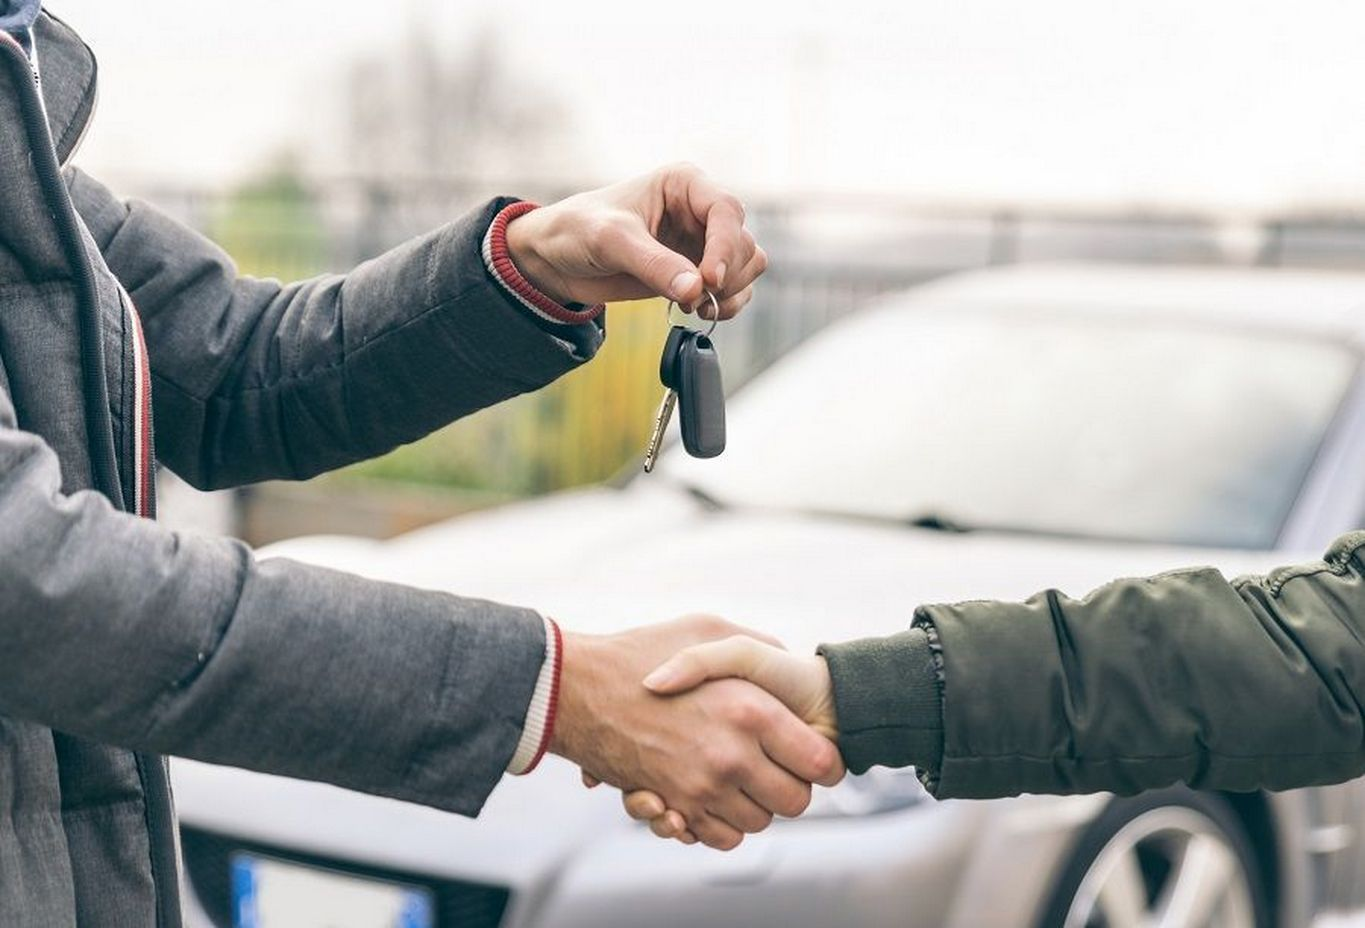

In [2]:
Image('https://raw.githubusercontent.com/rodrigogaf01/Previsao-Preco-dos-Carros/main/compracar.jpg', width= 700)

### Contexto

A CARSHOPEE atua no mercado automobilístico, caracterizada por ser uma empresa sólida, de tradição, que conjuga excelência no atendimento e veículos com rigorosa qualidade, com o objetivo único de tornar real o sonho de cada cliente.

Apostando em confiança e credibilidade como princípios fundamentais de sua atuação, a empresa busca no mercado somente veículos diferenciados, através de um rigoroso critério técnico de avaliação que garante qualidade e procedência.

A loja oferece automóveis de diversas marcas, semi-novos, Nacionais e Importados. Todos criteriosamente testados e avaliados, característica que a revenda traz consigo até hoje e a diferencia no mercado. E é assim que a CARSHOPEE solidificou a sua marca, com uma conduta ética e respeito a seus clientes, parceiros e fornecedores.

### Problema de Negócio

Em primeiro lugar, precisamos entender qual é o nosso problema de negócios. Portanto, criamos um contexto para nos ajudar a construir a solução. Então, vamos seguir essas quatro etapas.


- Qual é o contexto?

    * Em reunião com os gerentes da empresa, o dono demonstrou a sua procupação com o número de carros não vendidos.
    
    
    
- Qual é a causa?

     * O dono procura uma maneira de saber o preço ideal de revenda dos carros antes de comprá-lo, para analisar se vale a pena o negócio, porém não só com o 'achismo' de seus especialistas, mas também com algum algoritmo matemático.
     
     
### Etapas
        
Na próxima etapa, construiremos nossa solução. Portanto, seguiremos todas essas etapas a seguir.

- 0.0. IMPORTS
- 1.0. DESCRIÇÃO DOS DADOS
- 2.0. FEATURE ENGINEERING
- 3.0. FILTRANDO OS DADOS
- 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS
- 5.0. PREPARAÇÃO OS DADOS
- 6.0. SELEÇÃO DE FEATURES
- 7.0. MACHINE LEARNING
- 8.0. MAXIMIZANDO HIPERPARÂMETROS
- 9.0. INTERPRETANDO OS RESULTADOS

## 0.0. IMPORTS

In [1]:
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
from matplotlib.gridspec     import GridSpec
import seaborn               as sns
from scipy                   import stats    as ss
from datetime                import datetime
from IPython.display         import Image
from sklearn.preprocessing   import RobustScaler
from sklearn.metrics         import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.ensemble        import RandomForestRegressor, AdaBoostRegressor
import xgboost               as xgb
from boruta                  import BorutaPy 
import warnings

### 0.1. Funções de Ajuda

In [3]:
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

def titulo(titulo, tamanho= 20, y= 1):
    plt.title(titulo, fontsize= tamanho, color= 'grey', loc= 'left', fontweight= 'bold', y= y)
    

def cramer_v(x, y):
    cm= np.asmatrix(pd.crosstab(x,y))
    n= cm.sum()
    r, k= cm.shape
    
    chi2= ss.chi2_contingency(cm)[0]
    chi2corr= max(0, chi2 - (k - 1) * (r-1)/n - 1)
    kcorr= k - (k - 1) ** 2 / (n - 1)
    rcorr= r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))


def valor_grafico(data, height_plus= 0):
    for patch in ax.patches:
        height= patch.get_height()
        width= patch.get_width()
        left_coord= patch.get_x()

        ax.text(left_coord + width/2, height+ height_plus, '{:_}'.format(int(height)).replace('.',',').replace('_', '.'), ha= 'center')

### 0.2. Carregando Dados

In [4]:
raw_df= pd.read_csv('https://raw.githubusercontent.com/rodrigogaf01/Previsao-Preco-dos-Carros/main/dados.csv')

raw_df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


## 1.0. DESCRIÇÃO DOS DADOS

In [5]:
df1= raw_df.copy()

### 1.1. Dimensão dos Dados

In [6]:
print('O dataset possui {} linhas.'.format(df1.shape[0]))
print('O dataset possui {} linhas.'.format(df1.shape[1]))

O dataset possui 4345 linhas.
O dataset possui 9 linhas.


### 1.2. Tipo dos Dados

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4345 entries, 0 to 4344
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         4345 non-null   object 
 1   Price         4173 non-null   float64
 2   Body          4345 non-null   object 
 3   Mileage       4345 non-null   int64  
 4   EngineV       4195 non-null   float64
 5   Engine Type   4345 non-null   object 
 6   Registration  4345 non-null   object 
 7   Year          4345 non-null   int64  
 8   Model         4345 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 305.6+ KB


### 1.3. Valores Nulos

In [8]:
df1.isna().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
Model             0
dtype: int64

### 1.4. Preencher Valores Nulos
Vamos preencher as duas features que possuem valores nulos com a mediana de cada uma.

In [9]:
print('A mediana do Preço é : {}'.format(df1['Price'].median()))
print('A mediana da potência do motor é : {}'.format(df1['EngineV'].median()))

A mediana do Preço é : 11500.0
A mediana da potência do motor é : 2.2


In [10]:
df1['Price'].fillna(df1['Price'].median(), inplace= True)
df1['EngineV'].fillna(df1['EngineV'].median(), inplace= True)

### 1.5. Estatística Descritiva

In [11]:
num_att= df1.select_dtypes(include= ['int64', 'float64'])
cat_att= df1.select_dtypes(include= 'object')

#### 1.7.1. Atributos Numéricos

In [12]:
num_att.describe().round(2)

,Price,Mileage,EngineV,Year
count,4345.00,4345.00,4345.00,4345.00
mean,19105.28,161.24,2.77,2006.55
std,25120.13,105.71,4.98,6.72
min,600.00,0.00,0.60,1969.00
25%,7100.00,86.00,1.90,2003.00
50%,11500.00,155.00,2.20,2008.00
75%,20900.00,230.00,3.00,2012.00
max,300000.00,980.00,99.99,2016.00


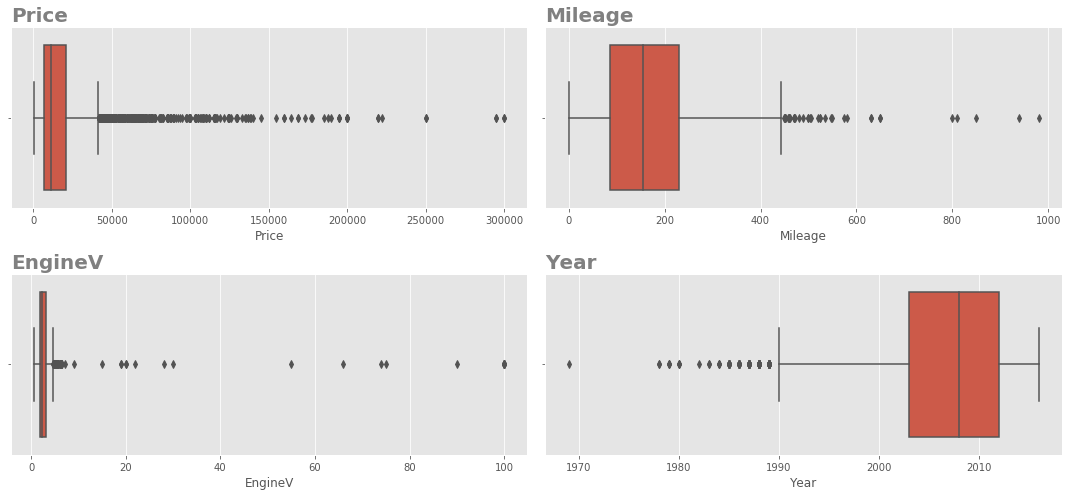

In [13]:
plt.figure(figsize= (15, 7))

n= 1
for i in num_att.columns:
    plt.subplot(2, 2, n)
    sns.boxplot(df1[i])
    titulo(i)
    
    n+= 1

plt.tight_layout()

#### 1.7.2. Atributos Categóricos

In [14]:
for i in cat_att.columns:
    print(i)
    print('Possui {} valores únicos.'.format(len(df1[i].unique())))
    print('Os valores únicos são: ', df1[i].unique())
    print('-'*100)

Brand
Possui 7 valores únicos.
Os valores únicos são:  ['BMW' 'Mercedes-Benz' 'Audi' 'Toyota' 'Renault' 'Volkswagen' 'Mitsubishi']
----------------------------------------------------------------------------------------------------
Body
Possui 6 valores únicos.
Os valores únicos são:  ['sedan' 'van' 'crossover' 'vagon' 'other' 'hatch']
----------------------------------------------------------------------------------------------------
Engine Type
Possui 4 valores únicos.
Os valores únicos são:  ['Petrol' 'Diesel' 'Gas' 'Other']
----------------------------------------------------------------------------------------------------
Registration
Possui 2 valores únicos.
Os valores únicos são:  ['yes' 'no']
----------------------------------------------------------------------------------------------------
Model
Possui 312 valores únicos.
Os valores únicos são:  ['320' 'Sprinter 212' 'S 500' 'Q7' 'Rav 4' 'GLS 63' 'A6' 'Megane'
 'Golf IV' '19' 'A6 Allroad' 'Passat B6' 'Land Cruiser 100' 'Clio'

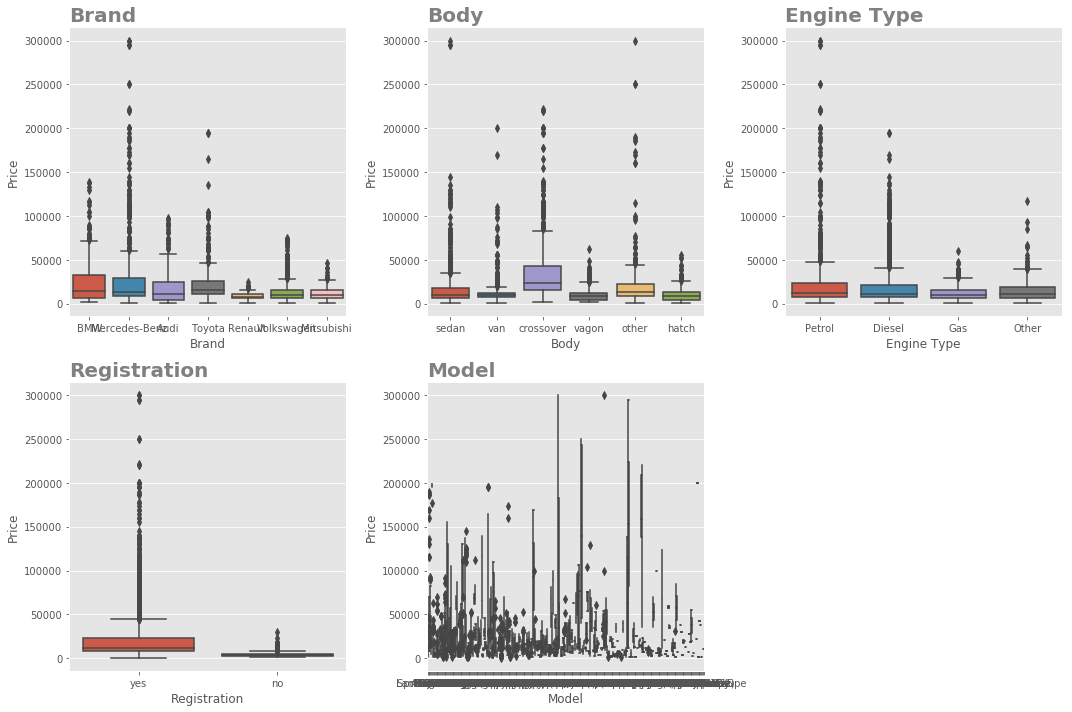

In [15]:
plt.figure(figsize= (15, 10))

n= 1
for i in cat_att.columns:
    plt.subplot(2, 3, n)
    sns.boxplot(x= i, y= 'Price', data= df1)
    titulo(i)
    
    n+= 1

plt.tight_layout()

## 2.0. FEATURE ENGINEERING

In [16]:
df2= df1.copy()

### 2.1. Mapa Mental de Hipóteses

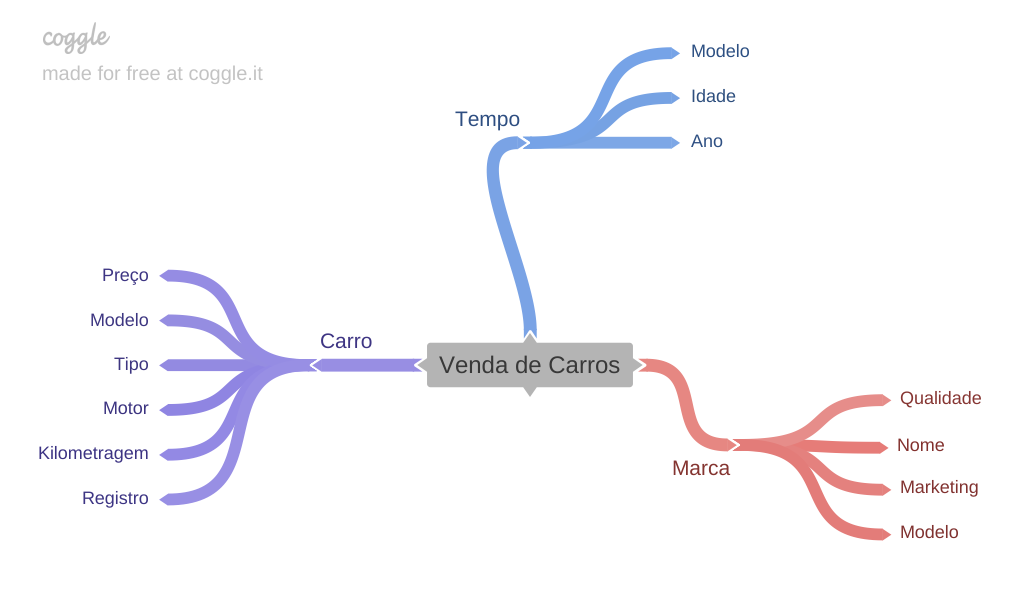

In [17]:
Image('https://raw.githubusercontent.com/rodrigogaf01/Previsao-Preco-dos-Carros/main/Venda_de_CarrosMindMap.png')

### 2.2. Lista de Hipóteses

**H1** Marca influencia no preço do carro.

**H2** O tipo de carro influencia no preço do carro.

**H3** Quanto maior a potência do motor, maior é o preço do carro.

**H4** Motores a Diesel são mais caros.

**H5** Carros registrados são mais caros.

**H6** Os carros tendem a ser mais caros quando são mais novos.

**H7** Os modelos mais caros são da BMW.

### 2.4. Feature Engineering
Nessa etapa, vamos criar uma coluna para kilometragem e outra para a idade do carro. Faremos isso com a ajuda das colunas já existentes.

In [18]:
# Kilometragem
df2['Kilometers']= df2['Mileage'] * 1.60934

# Idade
ano_atual= datetime.today().year
df2['Age']= ano_atual - df2['Year']

In [19]:
df2.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Kilometers,Age
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320,445.78718,30
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212,687.18818,22
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500,576.14372,18
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7,386.24160,14
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4,193.12080,10


## 3.0. FILTRANDO OS DADOS

In [20]:
df3= df2.copy()

### 3.1. Filtragem das Linhas
- Na descrição dos dados observamos que a coluna ````EngineV```` possui inconsistência nos dados pois depois de algumas pesquisas, vimos que um motor de carro normal pode ter uma potência de até 6.5V.

In [21]:
df3= df3[df3['EngineV'] <= 6.5]

In [22]:
print('Com esse filtro ainda mantivemos {:.2f}% dos dados.'.format(df3.shape[0] / raw_df.shape[0]))

Com esse filtro ainda mantivemos 0.99% dos dados.


### 3.2. Filtragem das Colunas
Vamos retirar ````Mileage e Year````, pois as duas serão substituidas pelas colunas criadas anteriormente(Kilometers e Age).

In [23]:
df3.drop(columns= ['Mileage', 'Year'], inplace= True)

In [24]:
print(df3.shape)
df3.head()

(4322, 9)


,Brand,Price,Body,EngineV,Engine Type,Registration,Model,Kilometers,Age
0,BMW,4200.0,sedan,2.0,Petrol,yes,320,445.78718,30
1,Mercedes-Benz,7900.0,van,2.9,Diesel,yes,Sprinter 212,687.18818,22
2,Mercedes-Benz,13300.0,sedan,5.0,Gas,yes,S 500,576.14372,18
3,Audi,23000.0,crossover,4.2,Petrol,yes,Q7,386.24160,14
4,Toyota,18300.0,crossover,2.0,Petrol,yes,Rav 4,193.12080,10


## 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS

In [25]:
df4= df3.copy()

### 4.1. Análise Univariada

#### 4.1.1 Variável Resposta

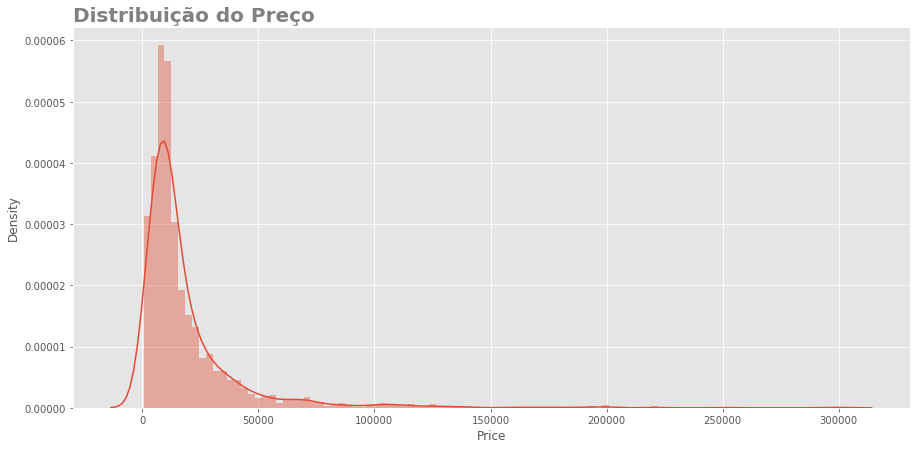

In [26]:
plt.figure(figsize= (15, 7))
sns.distplot(df4['Price'], bins= 100)
titulo('Distribuição do Preço')

#### 4.1.2 Variável Numérica

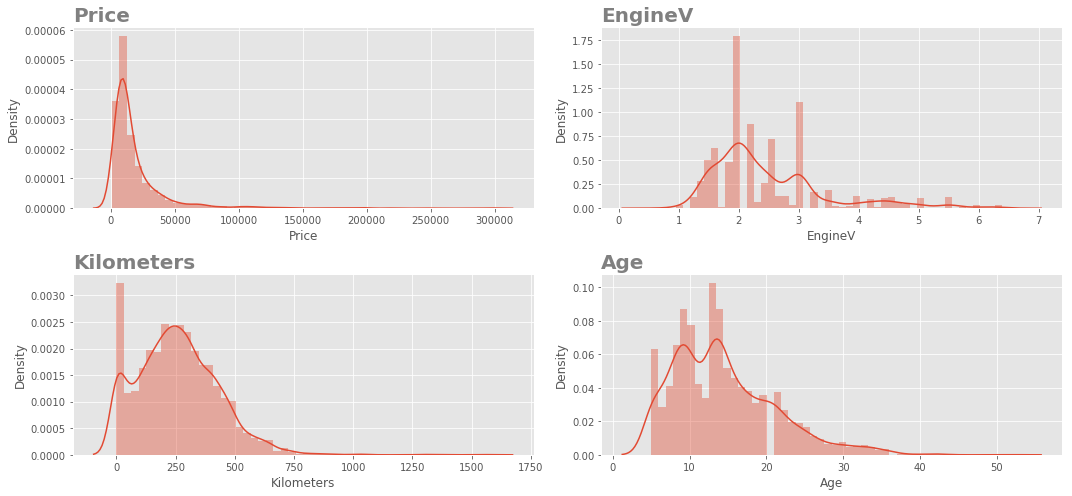

In [27]:
plt.figure(figsize= (15, 7))

n= 1
for i in df4.select_dtypes(include= ['int64', 'float64']):
    plt.subplot(2, 2, n)
    sns.distplot(df4[i], bins= 50)
    titulo(i)
    
    n+= 1

plt.tight_layout()

#### 4.1.3 Variável Categórica

In [28]:
df4.select_dtypes(include= ['object'])

,Brand,Body,Engine Type,Registration,Model
0,BMW,sedan,Petrol,yes,320
1,Mercedes-Benz,van,Diesel,yes,Sprinter 212
2,Mercedes-Benz,sedan,Gas,yes,S 500
3,Audi,crossover,Petrol,yes,Q7
4,Toyota,crossover,Petrol,yes,Rav 4
...,...,...,...,...,...
4340,Mercedes-Benz,sedan,Diesel,yes,S 350
4341,BMW,sedan,Petrol,yes,535
4342,BMW,sedan,Petrol,yes,520
4343,Toyota,sedan,Petrol,yes,Corolla


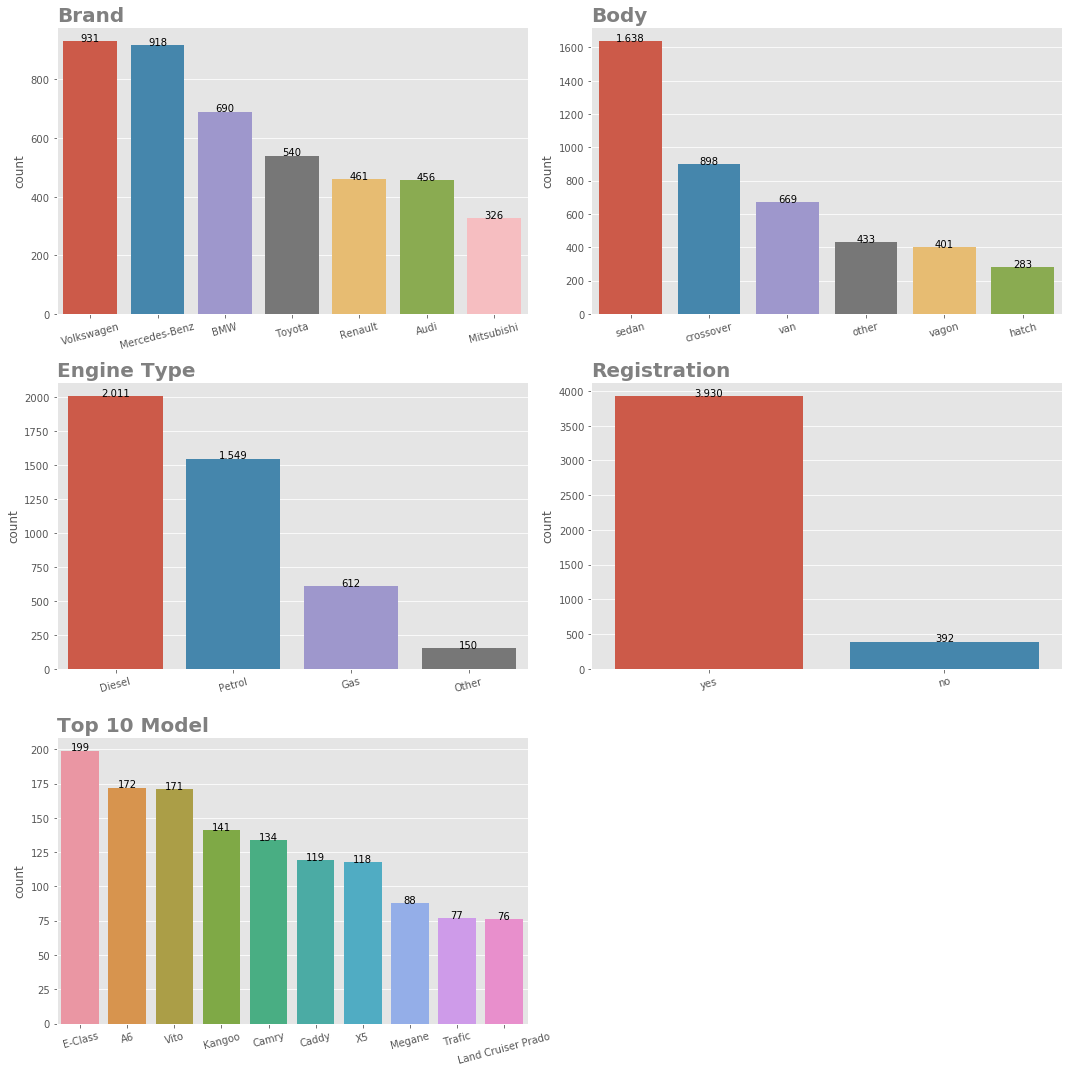

In [29]:
plt.figure(figsize= (15, 15))

n= 1
for i in df4.select_dtypes(include= ['object']).columns:
    plt.subplot(3, 2, n)
    ax= sns.countplot(x= df4[i], order= df4[i].value_counts().head(10).index)
    valor_grafico(df4)
    if i == 'Model':
        titulo('Top 10 Model')
    else:
        titulo(i)
    plt.xticks(rotation= 15)
    plt.xlabel('')
    
    n+= 1
    
plt.tight_layout()   

### 4.2. Análise Bivariada

**H1** Marca influencia no preço do carro.

**Verdadeiro**. Conseguimos observar que temos uma diferença entre os preços médios por cada marca. Para representar esse fato temos que a Volkswagen apresenta quase o mesmo número de carros que a Mercedes-Benz, porém quando vemos no valor total é muito abaixo.

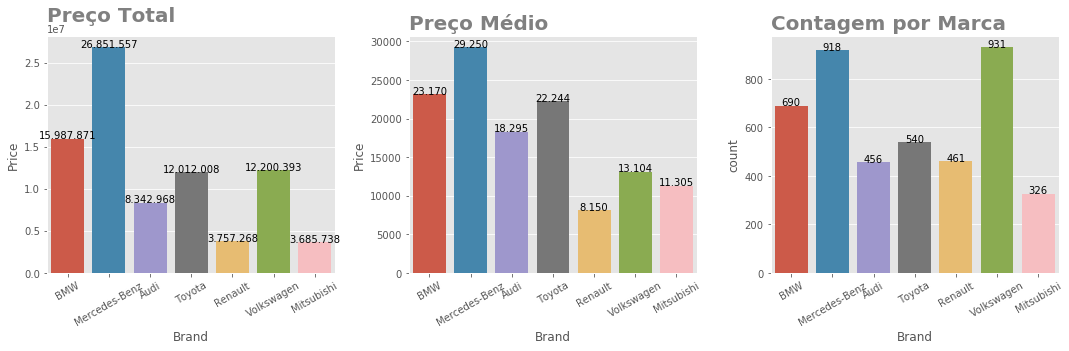

In [30]:
plt.figure(figsize= (15, 5))

plt.subplot(1, 3, 1)
ax= sns.barplot(x= 'Brand', y= 'Price', data= df4, estimator= sum, ci= None)
plt.xticks(rotation= 30)
titulo('Preço Total', y= 1.035)
valor_grafico(df4)

plt.subplot(1, 3, 2)
ax= sns.barplot(x= 'Brand', y= 'Price', data= df4, ci= None)
plt.xticks(rotation= 30)
titulo('Preço Médio')
valor_grafico(df4)

plt.subplot(1, 3, 3)
ax= sns.countplot(x= df4['Brand'])
plt.xticks(rotation= 30)
titulo('Contagem por Marca')
valor_grafico(df4)

plt.tight_layout();

**H2** O tipo de carro influencia no preço do carro.

**Verdadeiro**. Observamos que possui os tipos de carro apresentam uma grande diferença média de preços. Para representar esse fato temos que o tipo sedan apresenta quase o dobro da quantidade de carros que o tipo crossover, porém na soma total do preço dos carros apresenta um valor menor.

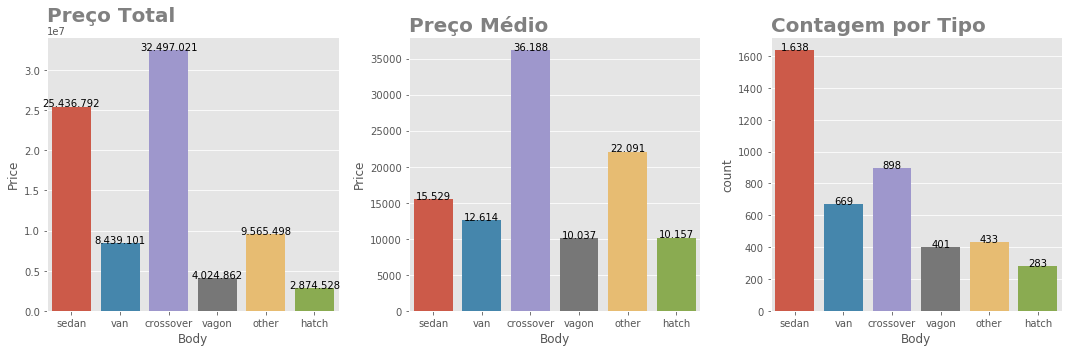

In [31]:
plt.figure(figsize= (15, 5))

plt.subplot(1, 3, 1)
ax= sns.barplot(x= 'Body', y= 'Price', data= df4, estimator= sum, ci= None)
titulo('Preço Total', y= 1.035)
valor_grafico(df4)


plt.subplot(1, 3, 2)
ax= sns.barplot(x= 'Body', y= 'Price', data= df4, ci= None)
titulo('Preço Médio')
valor_grafico(df4)

plt.subplot(1, 3, 3)
ax= sns.countplot(x= df4['Body'])
titulo('Contagem por Tipo')
valor_grafico(df4)

plt.tight_layout();

**H3** Quanto maior a potência do motor, maior é o preço do carro.

**Verdadeiro**. Observamos um aumento do preço conforme vai aumentando a potência. Compravada na correlação entre as duas de 0.43 o que significa uma correlação moderada.

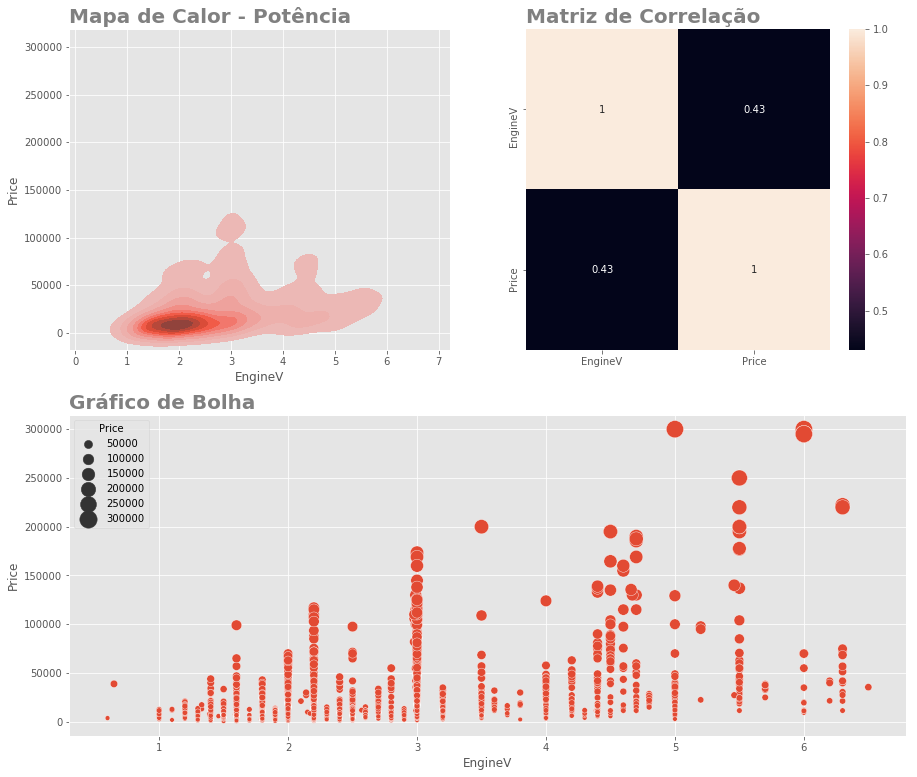

In [32]:
plt.figure(figsize= (15, 13))

grid= GridSpec(2, 2)

plt.subplot(grid[0,0])
sns.kdeplot(x= 'EngineV', y= 'Price', data= df4, fill= True)
titulo('Mapa de Calor - Potência')

plt.subplot(grid[0,1])
sns.heatmap(df4[['EngineV', 'Price']].corr(), annot= True)
titulo('Matriz de Correlação')

plt.subplot(grid[1, :])
sns.scatterplot(x= 'EngineV', y= 'Price', data= df4, size= 'Price', sizes= (20, 300))
titulo('Gráfico de Bolha')

**H4** Motores a Diesel são mais caros.

**Falso**. A maior média de preço por tipo de motor é o Petrol.

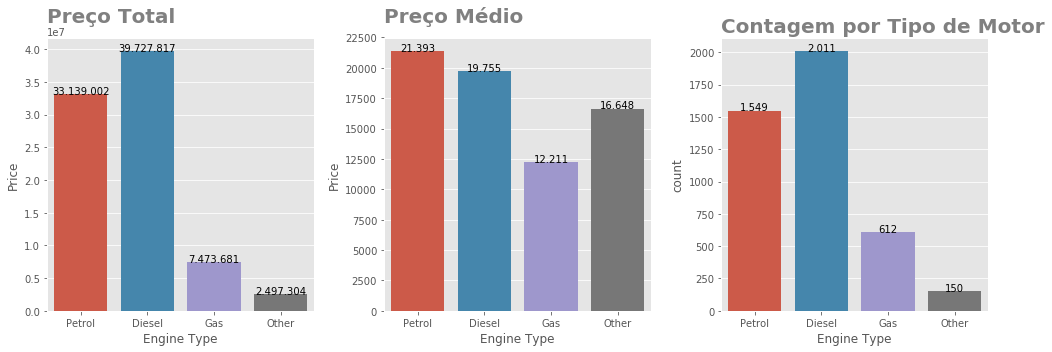

In [33]:
plt.figure(figsize= (15, 5))

plt.subplot(1, 3, 1)
ax= sns.barplot(x= 'Engine Type', y= 'Price', data= df4, estimator= sum, ci= None)
titulo('Preço Total', y= 1.035)
valor_grafico(df4)

plt.subplot(1, 3, 2)
ax= sns.barplot(x= 'Engine Type', y= 'Price', data= df4, ci= None)
titulo('Preço Médio', y= 1.035)
valor_grafico(df4)

plt.subplot(1, 3, 3)
ax= sns.countplot(x= df4['Engine Type'])
titulo('Contagem por Tipo de Motor')
valor_grafico(df4)

plt.tight_layout();

**H5** Carros registrados são mais caros.

**Verdade**. Observamos que a média de preço dos carros não resgistrados é muito inferior à aqueles que são registrados.

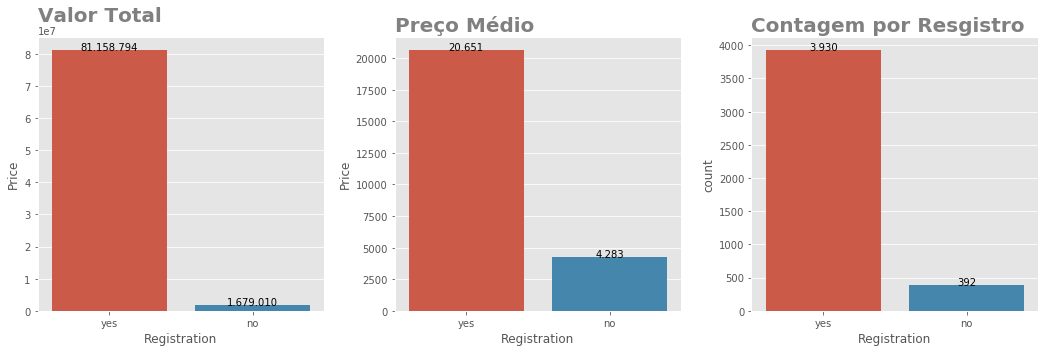

In [34]:
plt.figure(figsize= (15, 5))

plt.subplot(1, 3, 1)
ax= sns.barplot(x= 'Registration', y= 'Price', data= df4, estimator= sum, ci= None)
titulo('Valor Total', y= 1.035)
valor_grafico(df4)

plt.subplot(1, 3, 2)
ax= sns.barplot(x= 'Registration', y= 'Price', data= df4, ci= None)
titulo('Preço Médio')
valor_grafico(df4)

plt.subplot(1, 3, 3)
ax= sns.countplot(x= df4['Registration'])
titulo('Contagem por Resgistro')
valor_grafico(df4)

plt.tight_layout();

**H6** Os carros tendem a ser mais caros quando são mais novos.

**Verdade**. Observamos um aumento do preço conforme o carro é mais novo. Compravada na correlação entre as duas de -0.47 o que significa uma correlação moderada negativa, ou seja, quanto menor a idade, maior o preço.

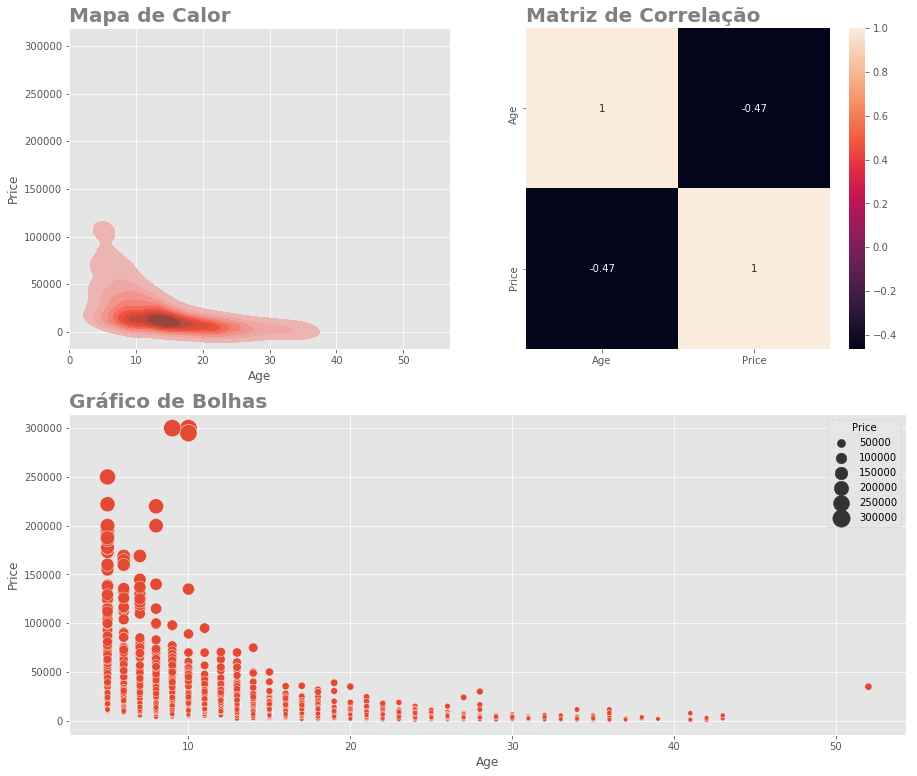

In [35]:
plt.figure(figsize= (15, 13))

grid= GridSpec(2, 2)

plt.subplot(grid[0,0])
sns.kdeplot(x= 'Age', y= 'Price', data= df4, fill= True)
titulo('Mapa de Calor')

plt.subplot(grid[0,1])
sns.heatmap(df4[['Age', 'Price']].corr(), annot= True)
titulo('Matriz de Correlação')

plt.subplot(grid[1, :])
sns.scatterplot(x= 'Age', y= 'Price', data= df4, size= 'Price', sizes= (20, 300))
titulo('Gráfico de Bolhas')

**H7** Os modelos mais caros são da BMW.

**Falso**. Observamos que em média os modelos da Mercedes-Benz são os mais caros.

In [36]:
aux1= df4[['Model', 'Brand', 'Price']].groupby(['Brand', 'Model']).agg(['count','sum', 'mean']).reset_index()
aux1.columns = list(map('_'.join, aux1.columns.values))

# Ordenando pela média do preço com carros que aparecem mais de 10 vezes
aux1= aux1[aux1['Price_count'] > 10].sort_values('Price_mean', ascending= False)
aux1

,Brand_,Model_,Price_count,Price_sum,Price_mean
126,Mercedes-Benz,GLS 350,24,2032321.0,84680.041667
246,Toyota,Land Cruiser 200,48,3231716.0,67327.416667
113,Mercedes-Benz,G 500,11,710899.0,64627.181818
117,Mercedes-Benz,GL 350,12,763654.0,63637.833333
177,Mercedes-Benz,V 250,13,795831.0,61217.769231
...,...,...,...,...,...
287,Volkswagen,Passat B4,15,60049.0,4003.266667
273,Volkswagen,Golf III,19,65749.0,3460.473684
286,Volkswagen,Passat B3,16,50549.0,3159.312500
1,Audi,80,15,39812.5,2654.166667


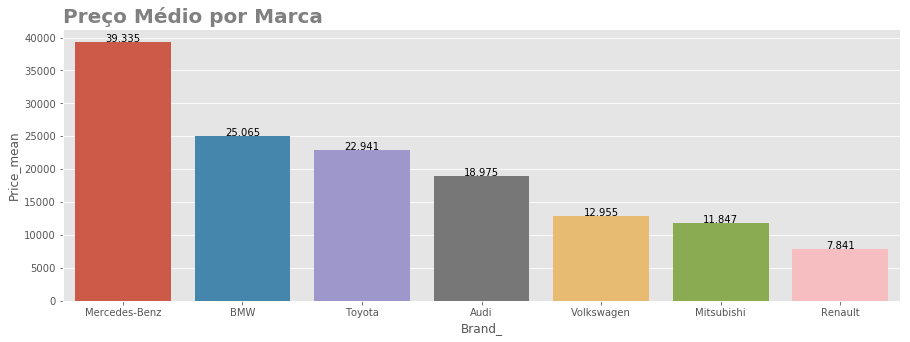

In [37]:
plt.figure(figsize= (15, 5))
aux2= aux1[['Brand_', 'Price_mean']].groupby('Brand_').mean().sort_values(by= 'Price_mean',ascending= False).index

ax= sns.barplot(x= 'Brand_', y= 'Price_mean', data= aux1, ci= None, order= aux2)
titulo('Preço Médio por Marca')
valor_grafico(df4)

### 4.3. Análise Multivariada

#### 4.3.1. Atributos Numéricos

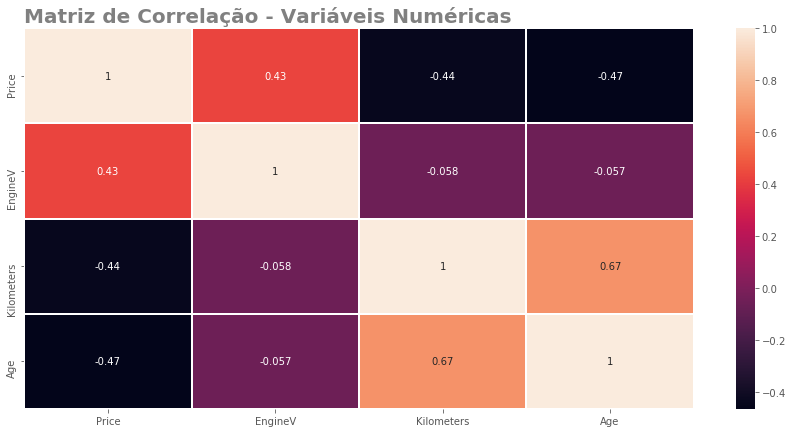

In [38]:
plt.figure(figsize= (15, 7))

num_att= df4.select_dtypes(include= ['float64', 'int64'])

sns.heatmap(num_att.corr(), annot= True, linewidths= 1)
titulo('Matriz de Correlação - Variáveis Numéricas')

#### 4.3.2. Atributos Categóricos

In [39]:
cat_att= df4.select_dtypes(include= 'object')

c1= cramer_v(cat_att['Brand'], cat_att['Brand'])
c2= cramer_v(cat_att['Brand'], cat_att['Body'])
c3= cramer_v(cat_att['Brand'], cat_att['Engine Type'])
c4= cramer_v(cat_att['Brand'], cat_att['Registration'])
c5= cramer_v(cat_att['Brand'], cat_att['Model'])

c6= cramer_v(cat_att['Body'], cat_att['Brand'])
c7= cramer_v(cat_att['Body'], cat_att['Body'])
c8= cramer_v(cat_att['Body'], cat_att['Engine Type'])
c9= cramer_v(cat_att['Body'], cat_att['Registration'])
c10= cramer_v(cat_att['Body'], cat_att['Model'])

c11= cramer_v(cat_att['Engine Type'], cat_att['Brand'])
c12= cramer_v(cat_att['Engine Type'], cat_att['Body'])
c13= cramer_v(cat_att['Engine Type'], cat_att['Engine Type'])
c14= cramer_v(cat_att['Engine Type'], cat_att['Registration'])
c15= cramer_v(cat_att['Engine Type'], cat_att['Model'])

c16= cramer_v(cat_att['Registration'], cat_att['Brand'])
c17= cramer_v(cat_att['Registration'], cat_att['Body'])
c18= cramer_v(cat_att['Registration'], cat_att['Engine Type'])
c19= cramer_v(cat_att['Registration'], cat_att['Registration'])
c20= cramer_v(cat_att['Registration'], cat_att['Model'])

c21= cramer_v(cat_att['Model'], cat_att['Brand'])
c22= cramer_v(cat_att['Model'], cat_att['Body'])
c23= cramer_v(cat_att['Model'], cat_att['Engine Type'])
c24= cramer_v(cat_att['Model'], cat_att['Registration'])
c25= cramer_v(cat_att['Model'], cat_att['Model'])


d= pd.DataFrame({'Brand': [c1, c2, c3, c4, c5],
                'Body': [c6, c7, c8, c9, c10],
                'Engine Type': [c11, c12, c13, c14, c15],
                'Registration': [c16, c17, c18, c19, c20],
                'Model':[c21, c22, c23, c24, c25]})
d= d.set_index(d.columns)

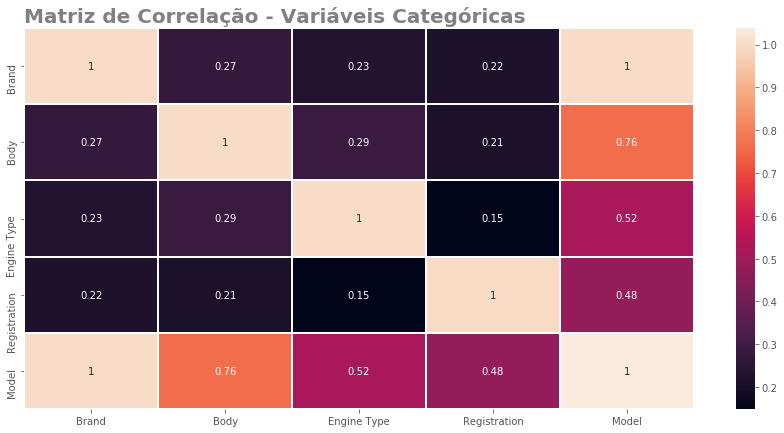

In [40]:
plt.figure(figsize= (15, 7))

sns.heatmap(d, annot= True, linewidths= 1)
titulo('Matriz de Correlação - Variáveis Categóricas')

## 5.0. PREPARAÇÃO DOS DADOS

In [41]:
df5= df4.copy()

### 5.1. Normalização
Como podemos observar na seção 4.1.2, não apresentamos nenhuma variável numérica com distribuição normal, então não faremos a normalização dos dados.

### 5.2. Reescaling
Primeiro vamos selecionar as variáveis numéricas para depois observar as features que possuem outliers e as que não possuem para aplicar diferentes métodos de reescaling, sendo o RobustScaler para o primeiro e o MinMaxScaler para o segundo.

Como demonstrado na seção 1.7.1, todas as variáveis numéricas apresentam outliers, por isso usaremos RobustScaler em todas as variáveis dependentes(x).

In [42]:
num_att_rb= df5[['EngineV', 'Kilometers', 'Age']]

rb= RobustScaler()

for i in num_att_rb.columns:               
    num_att_rb[i]= rb.fit_transform(num_att_rb[[i]].values)

num_att_rb

,EngineV,Kilometers,Age
0,-0.181818,0.847222,1.888889
1,0.636364,1.888889,1.000000
2,2.545455,1.409722,0.555556
3,1.818182,0.590278,0.111111
4,-0.181818,-0.243056,-0.333333
...,...,...,...
4340,0.727273,-1.013889,-0.666667
4341,1.181818,-1.069444,1.000000
4342,-0.181818,0.270833,2.555556
4343,0.000000,-0.861111,-0.666667


### 5.3. Transformação 

#### 5.3.1. Encoding

#### Label Enconder ####

- LabelEncoder é uma classe de utilitário para ajudar a normalizar rótulos de forma que contenham apenas valores entre 0 e n_classes-1. Pode ser usado para transformar rótulos não numéricos em rótulos numéricos.

#### One Hot Encoder ####

- Esse tipo de codificação pode ser obtido com o OneHotEncoder e get_dummies, que transforma cada recurso categórico com valores possíveis de n_categories em recursos binários de ncategories, sendo um deles 1 e todos os outros 0. Por padrão, os valores que cada recurso pode assumir são inferidos automaticamente do conjunto de dados e podem ser encontrados no atributo categorias.

#### Ordinal Encoder #### 

- Para converter recursos categóricos em códigos inteiros, podemos usar o OrdinalEncoder. Este estimador transforma cada recurso categórico em um novo recurso de números inteiros (0 a n_categories - 1) conforme ordenado.


Primeiramente vamos excluir a coluna model por existir um grande número de variáveis. Depois, vamos pegar as features que são objects e transforma-las em numéricas através do método **OneHotEncoder**.

In [43]:
cat_att_enc= df5.select_dtypes(include= 'object')
cat_att_enc= cat_att_enc.drop(columns= 'Model')

# Criando colunas
dummies= pd.get_dummies(cat_att_enc)

dummies.head()

,Brand_Audi,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_crossover,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Diesel,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_no,Registration_yes
0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1


#### 5.3.2. Variável Resposta
Vamos transformar a variável resposta o mais próxima de uma distribuição normal utilizando a função logaritmica.

In [44]:
var_resp= pd.Series(np.log(df5['Price']))

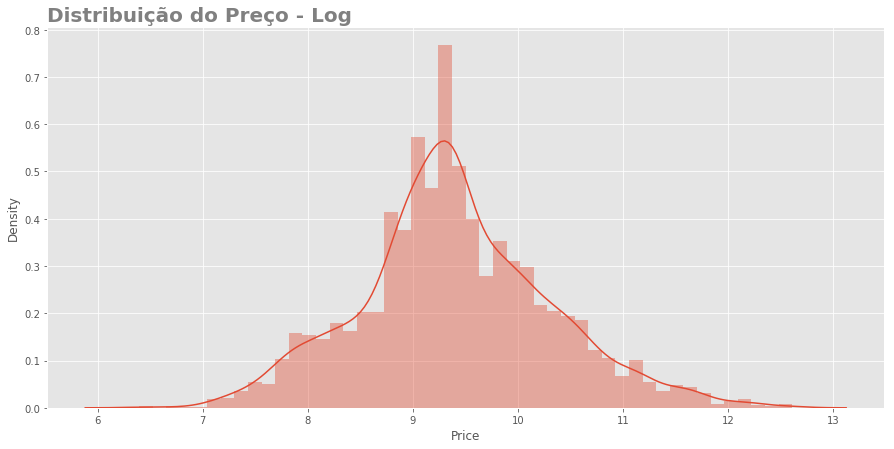

In [45]:
plt.figure(figsize= (15, 7))

sns.distplot(var_resp)
titulo('Distribuição do Preço - Log')

#### 5.3.2. Concatenando Features

In [46]:
df5= pd.concat([num_att_rb, dummies, var_resp], axis= 1)

df5.head()

,EngineV,Kilometers,Age,Brand_Audi,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,...,Body_sedan,Body_vagon,Body_van,Engine Type_Diesel,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_no,Registration_yes,Price
0,-0.181818,0.847222,1.888889,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,8.342840
1,0.636364,1.888889,1.000000,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,8.974618
2,2.545455,1.409722,0.555556,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,9.495519
3,1.818182,0.590278,0.111111,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,10.043249
4,-0.181818,-0.243056,-0.333333,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,9.814656


## 6.0. SELEÇÃO DE FEATURES

In [47]:
df6= df5.copy()

### 6.1. Separar o Dataset em Treino e Teste

In [48]:
x= df6.drop(columns= 'Price')
y= df6['Price']

In [49]:
# Definindo semente global
seed= 123
np.random.seed(seed)

x= df6.drop(columns= 'Price')
y= df6['Price']

x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.3, shuffle= True)

### 6.2. Random Forest

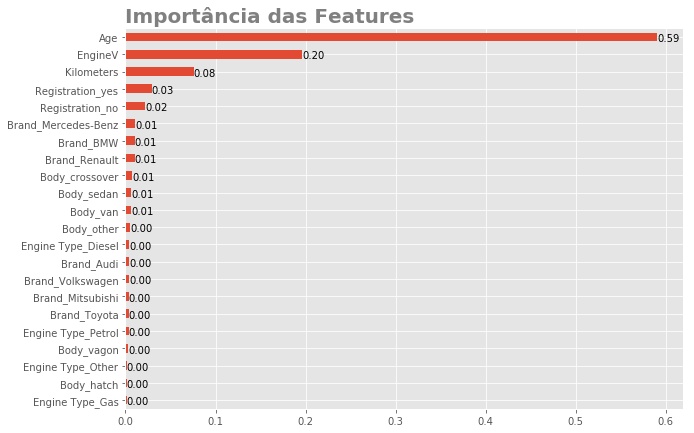

In [50]:
np.random.seed(seed)

# Definindo modelo
rf_model = RandomForestRegressor(n_jobs = -1)
rf_model.fit(x_train, y_train)

# Vendo as features selecionadas
feat_importances = pd.Series(rf_model.feature_importances_, index=x_train.columns)

plt.figure(figsize= (10, 7))
ax= feat_importances.sort_values().plot(kind='barh')
titulo('Importância das Features', 20)

for patch in ax.patches:
    width= patch.get_width()
    left_coord= patch.get_y()
    
    ax.text(width, left_coord, '{:.2f}'.format(width))

### 6.3. Boruta

In [51]:
np.random.seed(seed)

# Definindo modelo
rf_model = RandomForestRegressor(n_jobs = -1)

#define boruta
boruta = BorutaPy(rf_model, n_estimators = 'auto', verbose = 2, random_state = 123)
boruta.fit(np.array(x_train), np.array(y_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	18


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	18


BorutaPy(estimator=RandomForestRegressor(n_estimators=66, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x228805C7340),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x228805C7340, verbose=2)

In [52]:
#best features from boruta
cols_selected = boruta.support_.tolist()
cols_selected_boruta = x.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['EngineV', 'Kilometers', 'Age', 'Registration_yes']

### 6.4. Conclusão

Vimos que com apenas 4 features conseguimos quase 90% de importância do modelo de RandomForest. O modelo boruta selecionou as mesmas 4 features como mais importantes.

Como nosso projeto está no primeiro ciclo, vamos manter todas as variáveis e caso o nosso desempenho não seja o esperado, podemos pensar em alguma forma de melhorar esse passo.

## 7.0. MACHINE LEARNING
Após entendermos melhor nossos dados, a realidade da empresa e prepararmos nossos dados, é hora de utilizarmos Machine Learning para fazer previsões que podem nos ajudar a prever a venda ou não dos carros.

Para isso, avaliaremos a accurácia de 5 modelos diferentes de Machine Learning:

>* LinearRegression
>* Lasso
>* RandomForest
>* AdaBoost
>* XGBoost


### Validação Cruzada(Cross-Validation)

Para o resultado ser fiel a realidade e não ficar refém da sorte de uma aleatóriedade, utilizaremos validação cruzada. Para saber mais como funciona essa técnica, leia [este artigo](https://minerandodados.com.br/validacao-cruzada-aprenda-de-forma-simples-como-usar-essa-tecnica/#:~:text=A%20valida%C3%A7%C3%A3o%20cruzada%20%C3%A9%20uma,da%20modelagem%20%C3%A9%20a%20predi%C3%A7%C3%A3o.).

Nesse projeto iremos utilizar o KFold com o numero de folders igual a 10.

In [53]:
df7= df6.copy()

### 7.2. Modelos

In [54]:
models= []

models.append(['LinearRegression', LinearRegression()])
models.append(['Lasso', Lasso()])
models.append(['RandomForest', RandomForestRegressor(n_jobs = -1)])
models.append(['AdaBoost', AdaBoostRegressor()])
models.append(['XGBoost', xgb.XGBRegressor()])

models

[['LinearRegression', LinearRegression()],
 ['Lasso', Lasso()],
 ['RandomForest', RandomForestRegressor(n_jobs=-1)],
 ['AdaBoost', AdaBoostRegressor()],
 ['XGBoost',
  XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None)]]

### 7.3. Cross Validation

In [55]:
np.random.seed(seed)

# Gerar as predições para cada modelo
names= []
predictions= []


for name, model in models:
    kfold= KFold(n_splits= 10, shuffle= True)
    prediction= cross_val_predict(estimator= model, X= x_train, y= y_train, cv= kfold)
    
    names.append(name)
    predictions.append(prediction)

In [56]:
# Criar as métricas para avaliação dos modelos
MAE= []
MAPE= []
RMSE= []

for i in predictions:
    mae= mean_absolute_error(np.exp(y_train), np.exp(i))
    mape= mean_absolute_percentage_error(np.exp(y_train), np.exp(i))
    rmse= mean_squared_error(np.exp(y_train), np.exp(i))
    
    MAE.append(mae)
    MAPE.append(mape)
    RMSE.append(rmse)

In [57]:
# Adicionando em DataFrame
pd.DataFrame({'Modelo': names,
              'MAE': MAE,
              'MAPE': MAPE,
              'RMSE': RMSE})

,Modelo,MAE,MAPE,RMSE
0,LinearRegression,6563.562861,0.308374,3.152808e+08
1,Lasso,12443.433350,0.909841,7.009241e+08
2,RandomForest,5724.096587,0.287624,2.852829e+08
3,AdaBoost,7982.482475,0.395109,3.834927e+08
4,XGBoost,5770.758208,0.290194,3.338214e+08


Observamos que o melhor resultado foi o modelo RandomForest com uma média de erro de 5.498 o que corresponde aproximadamente 27% das predições reais.

## 8.0. Maximizando Hiperparâmetros

In [58]:
np.random.seed(seed)

n_estimators_values= [50, 100, 200, 500]
criterion_values= ['mse', 'mae']
max_depth_values= [3, 4, 6, 8, 10]
params_values= dict(n_estimators= n_estimators_values,
                    criterion= criterion_values,
                    max_depth= max_depth_values)

kfold= KFold(n_splits= 10, shuffle= True)
grid= GridSearchCV(estimator= RandomForestRegressor(n_jobs = -1), param_grid= params_values, scoring= 'neg_mean_absolute_percentage_error')
grid_result= grid.fit(x_train, y_train)

print('Melhores Parâmetros: {}'.format(grid_result.best_params_))

Melhores Parâmetros: {'criterion': 'mae', 'max_depth': 10, 'n_estimators': 200}


In [59]:
np.random.seed(seed)

rf_tuned= RandomForestRegressor(n_estimators= 500, criterion= 'mae', max_depth= 10, n_jobs = -1)

rf_tuned.fit(x_train, y_train)

y_pred= rf_tuned.predict(x_test)

mae= mean_absolute_error(np.exp(y_test), np.exp(y_pred))
mape= mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))
rmse= mean_squared_error(np.exp(y_test), np.exp(y_pred))

pd.DataFrame(data={'Modelo': 'RandomForest',
              'MAE': mae,
              'MAPE': mape,
              'RMSE': rmse}, index= [0])

,Modelo,MAE,MAPE,RMSE
0,RandomForest,5670.182103,0.281137,2.828965e+08


## 9.0. INTERPRETANDO OS RESULTADOS

### 9.1. Visualização dos Resultados

In [60]:
performance= pd.DataFrame(data= {'Y Real': np.exp(y_test), 'Y Previsto': np.exp(y_pred)})

performance['erro']= performance['Y Real'] - performance['Y Previsto']
performance['erro%']= (abs(performance['erro']) /  performance['Y Real']) * 100

performance.head()

,Y Real,Y Previsto,erro,erro%
2190,6900.0,6820.568794,79.431206,1.151177
3097,11500.0,71158.496645,-59658.496645,518.769536
3190,20900.0,20200.536655,699.463345,3.346715
912,8300.0,9888.214219,-1588.214219,19.135111
1799,7500.0,8004.409921,-504.409921,6.725466


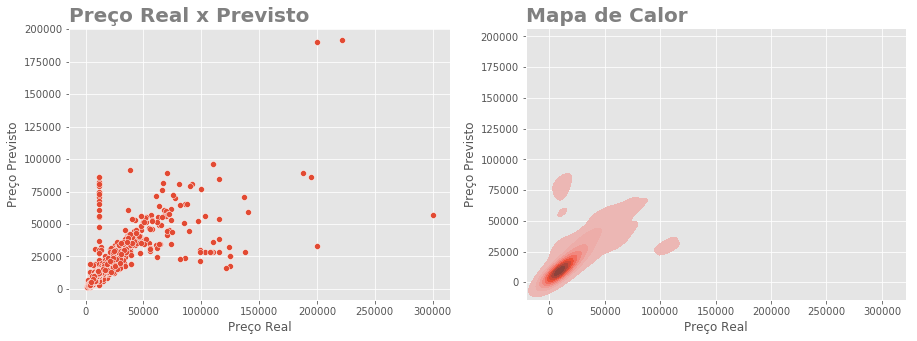

In [61]:
plt.figure(figsize= (15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x= 'Y Real', y= 'Y Previsto', data= performance)
plt.ylabel('Preço Previsto')
plt.xlabel('Preço Real')
titulo('Preço Real x Previsto')

plt.subplot(1, 2, 2)
ax= sns.kdeplot(x= 'Y Real', y= 'Y Previsto', data= performance, shade= True)
plt.ylabel('Preço Previsto')
plt.xlabel('Preço Real')
titulo('Mapa de Calor')

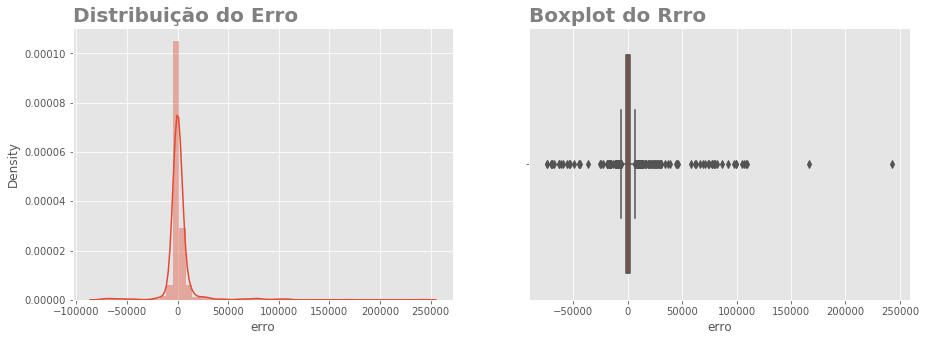

In [62]:
plt.figure(figsize= (15, 5))

plt.subplot(1, 2, 1)
sns.distplot(performance['erro'])
titulo('Distribuição do Erro')

plt.subplot(1, 2, 2)
sns.boxplot(x= 'erro', data= performance)
titulo('Boxplot do Rrro')

In [63]:
performance.sort_values('erro%', ascending= False).head(15)

,Y Real,Y Previsto,erro,erro%
2057,11500.0,86089.732485,-74589.732485,648.606369
1175,11500.0,86089.732485,-74589.732485,648.606369
1053,11500.0,82230.881481,-70730.881481,615.051143
2992,11500.0,80815.752615,-69315.752615,602.745675
838,11500.0,80815.752615,-69315.752615,602.745675
571,11500.0,80815.752615,-69315.752615,602.745675
2166,11500.0,79109.338567,-67609.338567,587.907292
3779,11500.0,74749.340867,-63249.340867,549.994268
806,11500.0,74740.567575,-63240.567575,549.917979
595,11500.0,73216.896901,-61716.896901,536.668669


### 9.2. Conclusão

- O modelo de regressão RandomForest obteve um erro absoluto médio(MAE) de  R$ 5.670 , o que significa 28% de erro médio absoluto percentual(MAPE) nas previsões.

- Observando o gráfico da Previsão x Real de Vendas, podemos ver que o modelo teve mais dificuldade em prever aqueles que possuem um valor muito baixo e um valor muito alto.

- Através da tabela, vemos que os maiores erros são daqueles que possuem um valor de R$ 11.500 , pois o modelo superestimou a sua previsão.

- Observando o histograma, a distribuição do erro tem o formato de uma normal, porém apresenta muitos outliers por conta dos problemas já descritos acima.

### 9.3. Próximos Passos
- Obter mais dados para nosso modelo conseguir treinar mais e encontrar novos padrões.
- Reconstruir a feature engineering e encoding para encontrar novas variáveis que o modelo veja com maior importância.
- Retirar outliers, principalmente os de preço muito baixo, irá melhorar a performace do modelo.